In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import scipy

import math
from livelossplot import PlotLosses

from sklearn.metrics import roc_curve, auc


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


# Explore Data

In [2]:
rating_df = pd.read_csv('./book-data/ratings.csv', header = 0)
rating_df.shape

(981756, 3)

In [3]:
rating_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
# books_df = pd.read_csv('./book-data/books.csv', header = 0)
# books_df.head()

# Data Process

In [5]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, user_item_pairs, ratings):
        'Initialization'
        self.labels  = ratings
        self.samples = user_item_pairs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.samples)

    def __getitem__(self, index):
        'Generates one sample of data'
        # # Load data and get label
        #print("called get item")
        user_item_pair = self.samples[index].astype('long')
        user_social = np.zeros(64).astype('long') #convert to actual social embeddings later
        user_item_pair_social = np.concatenate((user_item_pair, user_social), axis=None)
        X = user_item_pair_social
        y = self.labels[index]
        return X, y

In [6]:
def pre_process_rating(df,count):
    user_rating_count = df.groupby('user_id')['user_id'].agg(['count']).reset_index()
    cdf = df.merge(user_rating_count, on='user_id')
    cdf = cdf[cdf['count']>count][['user_id','book_id','rating']]
    user_bias = cdf['user_id'].min()
    cdf[['user_id']] -user_bias
    # num_users = len(user_rating_count)
    
    num_users = int(cdf['user_id'].max() - cdf['user_id'].min() + 1)
    num_items = int(cdf['book_id'].max() - cdf['book_id'].min() + 1)
    
    total_ratings = np.array(cdf.values)
    total_ratings[:,0:1]-= cdf['user_id'].min()
    user_item_pairs = total_ratings[:,0:2]
    ratings = total_ratings[:,2:3]
    dataset = Dataset(user_item_pairs,ratings)
    
    return {"rating_df":cdf,"dataset":dataset ,"num_users":num_users,"num_items":num_items,"user_bias":user_bias}

# Models


## Generalized Matrix Factorization 

An abstrsct of traditional MF method, the products of embeding layout are ratings of user give to each item
if only use one dimention it will be traditional MF, but the neural network has expand that structure, and allows it can catch the features that traditional MF model can't catchs.

element-wise


In [7]:
class GMF(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        
        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim,sparse=True)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim,sparse=True)
        self.fc = nn.Linear(in_features=self.latent_dim, out_features=1, bias=True)
        
    def forward(self, user_indices, item_indices):
        user_embedding = F.relu(self.embedding_user(user_indices))
        item_embedding = F.relu(self.embedding_item(item_indices))
        return F.relu(self.fc(user_embedding * item_embedding))

## Multi-Layer Perceptron 

concatenation

The GMF only use one layer, but MLP use multi-layout 

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, num_users, num_items,latent_dim=8,layers = [16,32,16,8]):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim,sparse=True)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim,sparse=True)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=layers[-1], out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
#         print("item_embedding")
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
#         print("vector",vector)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        out = self.affine_output(vector)
#         rating = self.logistic(logits)
        return out

## Neural Matrix Factorization 

In [9]:
class NeuMF(torch.nn.Module):
    def __init__(self,  num_users, num_items,latent_dim_mf=8,latent_dim_mlp=8,layers=[16,32,16,8]):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim_mf = latent_dim_mf
        self.latent_dim_mlp = latent_dim_mlp

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp,sparse=True)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp,sparse=True)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf,sparse=True)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf,sparse=True)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=layers[-1] + latent_dim_mf, out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        out = self.affine_output(vector)
#         rating = self.logistic(logits)
        return out

In [10]:
def predict_eval(model, generator):
    model.eval()
    y_preds_all = torch.Tensor().to(device) 
    y_labels_all = torch.Tensor().to(device) 
    y_pairs_all = torch.Tensor().type(torch.long).to(device) 
    
    for local_batch, local_labels in generator:
        local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
        local_labels = local_labels.type(torch.float).to(device)
        with torch.no_grad():
            y_preds = model(local_batch[:,0], local_batch[:,1])
        y_preds_all = torch.cat((y_preds_all,y_preds))
        y_labels_all = torch.cat((y_labels_all,local_labels))
        y_pairs_all = torch.cat((y_pairs_all,local_batch[:,0:2]))
        
    return y_preds_all, y_labels_all ,y_pairs_all


In [27]:
num_items

10000

In [11]:
def predict(model,user_id):
    user_rating_pair = [(np.zeros((num_items)) + user_id),np.arange(0,num_items,1)]
    local_batch  = torch.tensor(user_rating_pair).type(torch.long).to(device)
    with torch.no_grad():
        y_preds = model(local_batch[0], local_batch[1])
    return y_preds

In [12]:
def epoch_run(model, generator, opt, criterion,liveloss,mode="train"):
    running_loss = 0
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    i = 0
    for local_batch, local_labels  in generator:
        local_batch  = torch.tensor(local_batch).type(torch.long).to(device)
        local_labels = local_labels.type(torch.float).to(device)
        
        y_preds = model(local_batch[:,0], local_batch[:,1])
        loss = criterion(y_preds, local_labels)

        running_loss += (loss.item()*local_labels.size()[0])
        if(mode == "train"):
            opt.zero_grad()
            loss.backward()
            opt.step()
            liveloss.update({
                'mse':loss.item()
            })
            liveloss.draw()

#  Train

In [13]:
# preprocess data
pre_processed = pre_process_rating(rating_df,50)
train_df = pre_processed["rating_df"]
num_users = pre_processed["num_users"]
num_items = pre_processed["num_items"]
train_dataset = pre_processed["dataset"]
user_bias = pre_processed["user_bias"]

In [14]:
sample_params = {'batch_size': 51200,'shuffle': True,'num_workers': 0}
train_generator = torch.utils.data.DataLoader(train_dataset, **sample_params)

In [15]:
liveloss1 = PlotLosses()
liveloss2 = PlotLosses()
liveloss3 = PlotLosses()

In [17]:
# # define model
# NeuMF_model = NeuMF(num_users+1,num_items+1,16,8).to(device)
# NeuMF_opt = optim.SGD(NeuMF_model.parameters(),lr=0.001)
# NeuMF_criterion = torch.nn.MSELoss()
NeuMF_model.load_state_dict(torch.load("./rs_server/checkpoints/neumf_899.pkg",map_location='cpu'))

<All keys matched successfully>

In [43]:
torch.save(NeuMF_model, "./rs_server/checkpoints/neumf_model.pkg")

In [25]:
test_model = torch.load("./rs_server/checkpoints/neumf_model.pkg")

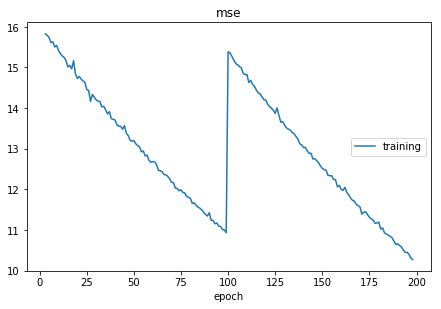

mse:
training   (min:   10.276, max:   15.980, cur:   10.276)


In [93]:
for i in range(0,11):
    epoch_run(NeuMF_model,train_generator,NeuMF_opt,NeuMF_criterion,liveloss1,"train")
    if i %5:
        torch.save(NeuMF_model.state_dict(), "./md_checkpoint/neumf_8"+str(i)+".pkg")

In [63]:
# define model
MLP_model = MLP(num_users+1,num_items+1).to(device)
MLP_opt = optim.SGD(MLP_model.parameters(),lr=0.01)
MLP_criterion = torch.nn.MSELoss()
# MLP_model.load_state_dict(torch.load("./md_checkpoint/mlp_.pkg"))

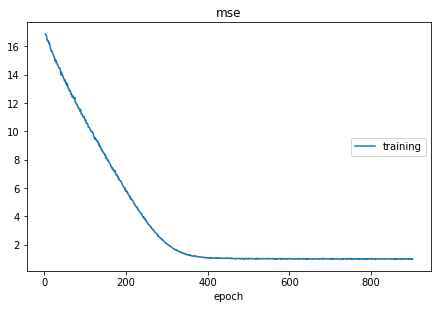

mse:
training   (min:    0.948, max:   17.018, cur:    0.984)


In [64]:
for i in range(0,11):
    epoch_run(MLP_model,train_generator,MLP_opt,MLP_criterion,liveloss2,"train")
    if i %5:
        torch.save(MLP_model.state_dict(), "./md_checkpoint/mlp_"+str(i)+".pkg")

In [16]:
# torch.save(NeuMF_model.state_dict(), "./md_checkpoint/neumf_1.pkg")

# Eval and Test

In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def rmse(pred,label):
    return sqrt(mean_squared_error(pred,label))

In [19]:
rating_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [20]:
# show result contrast
USERID = 1169
predict_y = predict(NeuMF_model,USERID-user_bias)
predict_df = pd.DataFrame(predict_y.to("cpu").numpy(),columns=["predict"]).reset_index()
contrast_df = rating_df[rating_df['user_id']==USERID].merge(
    predict_df,left_on="book_id",right_on="index")[['user_id','book_id','rating','predict']]

In [21]:
rmse(np.array(contrast_df["rating"]),np.array(contrast_df["predict"]))

0.7901030120766089

In [22]:
contrast_df[contrast_df['rating']>=4].head()

,user_id,book_id,rating,predict
0,1169,1,4,3.605298
2,1169,4,5,3.670433
3,1169,5,5,3.524496
4,1169,11,4,3.815585
7,1169,15,4,3.506951


In [65]:
# show result contrast
USERID = 1169
predict_y = predict(MLP_model,USERID-user_bias)
predict_df = pd.DataFrame(predict_y.to("cpu").numpy(),columns=["predict"]).reset_index()
contrast_df = rating_df[rating_df['user_id']==USERID].merge(
    predict_df,left_on="book_id",right_on="index")[['user_id','book_id','rating','predict']]

In [66]:
rmse(np.array(contrast_df["rating"]),np.array(contrast_df["predict"]))

0.812214965911265

In [1]:
# contrast_df[contrast_df['rating']>=4]


In [36]:
a = predict_y.numpy()

In [37]:
np.argmax(a)

9601

In [39]:

print(np.argmax(a, axis=0))

[9601]


In [41]:
a[45] = 0

In [42]:
a[45]

array([0.], dtype=float32)

In [44]:
num_users

53375